In [8]:
import unified_bib as uf
from importlib import reload
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold,StratifiedKFold

In [2]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from tsfresh.feature_extraction import extract_features, ComprehensiveFCParameters
from tsfresh.feature_extraction.settings import from_columns
from tsfresh.feature_extraction import feature_calculators
from tsfresh.feature_extraction import EfficientFCParameters
import pickle
import pandas as pd
import tsfresh
from psutil import cpu_percent
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt

# Filtering TSFRESH Features
- Given an `output_id`, this function withdraw all NaN features from the TSFRESH extraction 

In [3]:
uf.tsfresh_NaN_filter('100')

Feature Extraction: 100%|██████████| 20/20 [17:35<00:00, 52.77s/it]  


Percentage of invalid features:  0.6418485237483954
Percentage of valid features:  99.3581514762516


# Using original data
## Training phase
### Cross-validation

In [5]:
output_id = '100'
full_data = np.genfromtxt('Input/Output_' + output_id + '.csv',
                                delimiter=',')

In [11]:
target = full_data[:,-1]
ID = full_data[:,0]
diam_target = np.ones((target.shape))

diam_target[target==0] = 0
diam_target[0:112*750] = -1

unique_id, id_idx= np.unique(ID,return_index=True)
skf_target = target[id_idx]

In [13]:
kf = StratifiedKFold(n_splits=5)

for kf_train_idx, kf_test_idx in kf.split(unique_id,skf_target):
    id_train = [unique_id[i] for i in kf_train_idx]
    id_test = [unique_id[i] for i in kf_test_idx]

In [15]:
train_index =[]
test_index =[]

for i in range(len(ID)):
    if ID[i] in id_train:
        train_index.append(i)
        
    elif ID[i] in id_test:
        test_index.append(i)

train_set = full_data[train_index,:]
test_set = full_data[test_index,:]

_,train_index_first_occurance = np.unique(train_set[:,0],return_index=True)
_,test_index_first_occurance = np.unique(test_set[:,0],return_index=True)

train_set_target = train_set[train_index_first_occurance.tolist(),-1]
test_set_target = test_set[test_index_first_occurance.tolist(),-1]

In [18]:
SelectedFeatures = uf.tsfresh_chucksize(train_set,output_id)
#SelectedFeatures = uf.tsfresh_extraction(9)

Feature Extraction: 100%|██████████| 20/20 [02:27<00:00,  7.38s/it]


             
PCA Control Output
----------------------------------
Variation maintained: 39.11
                  
Filtered Features
--------------------
602
1032
--------------------
Reduced Features
--------------------
602
4


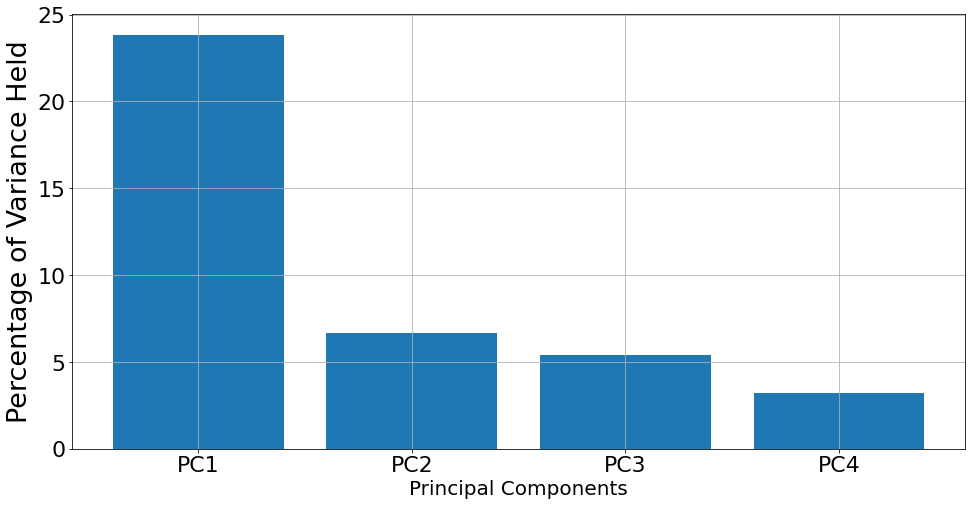

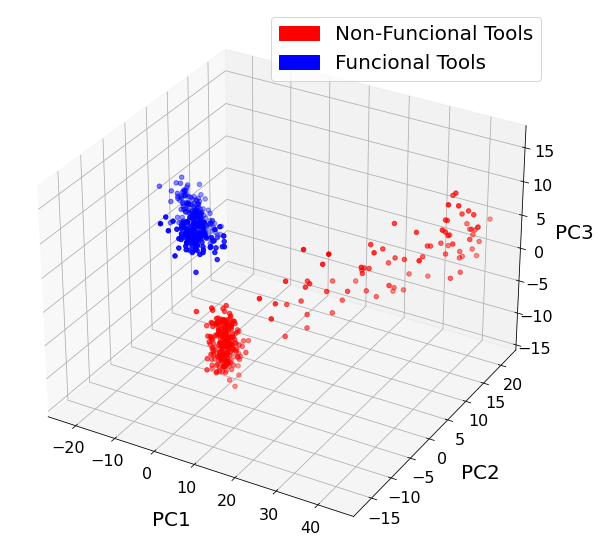

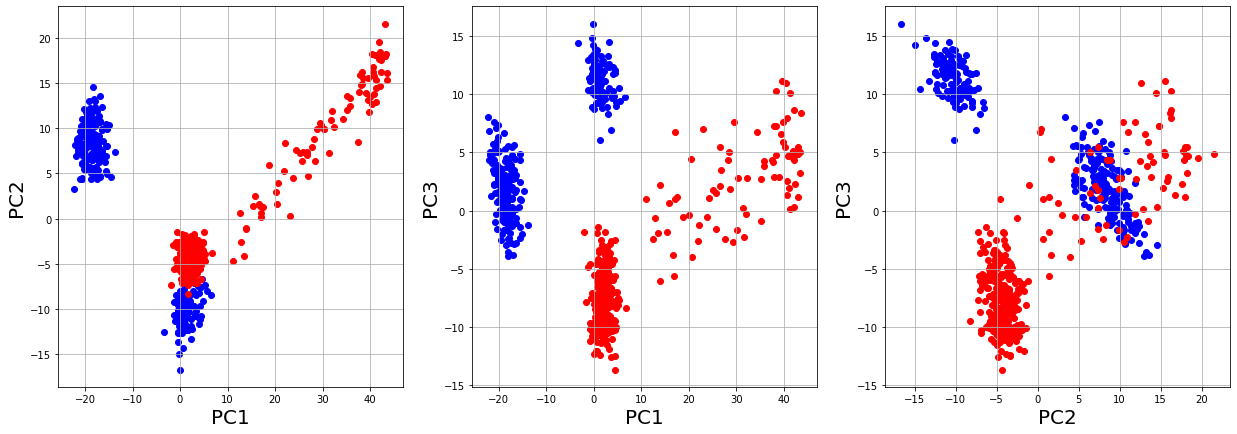

In [155]:
ReducedFeatures = uf.PCA_calc(SelectedFeatures,4,'Calc') # (Feautures selecionadas, numero de PC's a manter, mode ('Test','Calc','Specific', 'Analytics'))

In [172]:
SODA_parameters = uf.SODA(ReducedFeatures,1,2,1) # (Features reduzidas, granularidade mínima, granularidade máxima, passo)

Processing granularity 1
Processing granularity 2


In [173]:
GA_parameters = uf.GroupingAlgorithm(SODA_parameters)

             
Grouping Algorithm Control Output
----------------------------------
granularity_1
Number of data clouds: 1
Number of good tools groups: 0
Number of worn tools groups: 1
Number of samples: 602
---------------------------------------------------
granularity_2
Number of data clouds: 4
Number of good tools groups: 2
Number of worn tools groups: 2
Number of samples: 602
---------------------------------------------------


## Testing phase

In [24]:
extracted_features, ets = uf.dynamic_tsfresh(test_set, 'test')

Feature Extraction: 100%|██████████| 150/150 [00:55<00:00,  2.73it/s]


In [165]:
projected_features = uf.PCA_projection(extracted_features,4)

Variation maintained: 99.17
                  


In [199]:
reload(uf)

<module 'unified_bib' from '/home/thiago/Repositories/Learning/Python/JCAE_Major/unified_bib.py'>

In [200]:
Classifiers_result = uf.non_parametric_classification(ReducedFeatures['ReducedFeatures'],projected_features,
                     GA_parameters,test_set_target)

-------------------------------------
granularity_1
-------------------------------------
granularity_2


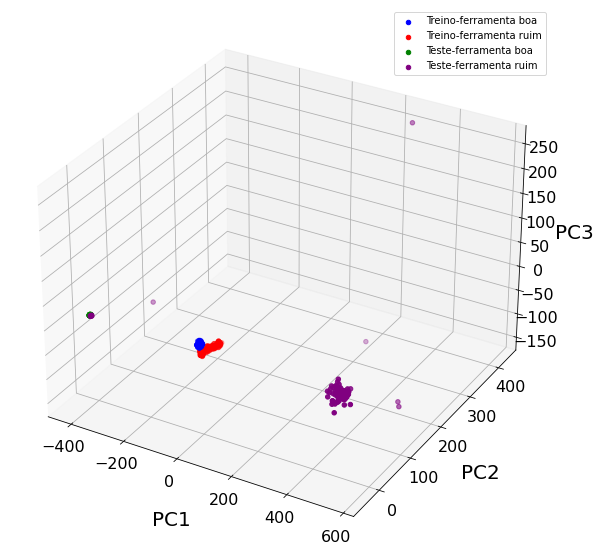

In [27]:
training_data = ReducedFeatures['ReducedFeatures']
test_data = projected_features

fig = plt.figure(figsize=[14,10])
ax = fig.add_subplot(111, projection='3d')

# Treino

ax.scatter(training_data[train_set_target== 0,0], 
           training_data[train_set_target== 0,1], 
           training_data[train_set_target== 0,2], 
           c = 'b',label='Treino-ferramenta boa')

ax.scatter(training_data[train_set_target == 1,0], 
           training_data[train_set_target == 1,1], 
           training_data[train_set_target == 1,2], 
           c = 'r',label='Treino-ferramenta ruim')

# Teste
           
ax.scatter(test_data[test_set_target== 0,0], 
           test_data[test_set_target== 0,1], 
           test_data[test_set_target== 0,2], 
           c = 'g',label='Teste-ferramenta boa')

ax.scatter(test_data[test_set_target == 1,0], 
           test_data[test_set_target == 1,1], 
           test_data[test_set_target == 1,2], 
           c = 'purple',label='Teste-ferramenta ruim')

plt.ylabel('PC2',fontsize = 20,labelpad=18)
plt.xlabel('PC1',fontsize = 20, labelpad=18)
ax.set_zlabel('PC3', fontsize = 20, labelpad=12)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='z', labelsize=16)

ax.grid()
plt.legend()

plt.show()

# Misc

In [25]:
projected_features[:,1] *= -1

In [30]:
ClassificationPar = uf.GroupingAlgorithm(SODA_parameters,95, processing_parameters) # (Labels do SODA, Porcentagem de definição, numero de ID's boas, parametros de processamento)

             
Grouping Algorithm Control Output
----------------------------------
SODA_euclidean_label_104_2.00.csv
Number of data clouds: 2
Number of good tools groups: 0
Number of worn tools groups: 1
Number of excluded data clouds: 1
Number of samples: 1722
Number of good tools samples: 10
Number of worn tools samples: 846
Number of excluded samples: 866
Data representation loss: 50.29
Analyse execution time: 2.017764 segundos
Avarage CPU usage: 17.82
---------------------------------------------------
SODA_euclidean_label_104_2.25.csv
Number of data clouds: 2
Number of good tools groups: 0
Number of worn tools groups: 1
Number of excluded data clouds: 1
Number of samples: 1722
Number of good tools samples: 20
Number of worn tools samples: 761
Number of excluded samples: 941
Data representation loss: 54.65
Analyse execution time: 3.032117 segundos
Avarage CPU usage: 17.36
---------------------------------------------------
SODA_euclidean_label_104_2.50.csv
Number of data clouds: 5


SODA_euclidean_label_104_6.75.csv
Number of data clouds: 413
Number of good tools groups: 161
Number of worn tools groups: 252
Number of excluded data clouds: 0
Number of samples: 1722
Number of good tools samples: 738
Number of worn tools samples: 984
Number of excluded samples: 0
Data representation loss: 0.00
Analyse execution time: 27.285093 segundos
Avarage CPU usage: 19.83
---------------------------------------------------
SODA_euclidean_label_104_7.00.csv
Number of data clouds: 451
Number of good tools groups: 176
Number of worn tools groups: 275
Number of excluded data clouds: 0
Number of samples: 1722
Number of good tools samples: 738
Number of worn tools samples: 984
Number of excluded samples: 0
Data representation loss: 0.00
Analyse execution time: 28.313315 segundos
Avarage CPU usage: 20.40
---------------------------------------------------
SODA_euclidean_label_104_7.25.csv
Number of data clouds: 489
Number of good tools groups: 198
Number of worn tools groups: 291
Numbe

In [ ]:
# Alarm tag
while True:
    os.system("printf '\a'") # or '\7'
    time.sleep(0.001)

In [ ]:
# Alarm tag
while True:
    os.system("printf '\a'") # or '\7'
    time.sleep(0.001)

In [ ]:
os.chdir(r'C:\Users\mathe\OneDrive\Documentos\GitHub\Lathes_Tool_Project')

In [ ]:
# .Recovery

if True:
    print('Recovery Control Output')
    print('----------------------------------')

    D_S_parameters =  Recovery('D_S_parameters') 
    ExtractedNames =  Recovery('ExtractedNames') 
    SelectedFeatures =  Recovery('SelectedFeatures') 
    ReducedFeatures =  Recovery('ReducedFeatures') 
    
    Output_ID = int(D_S_parameters['ID'])

    print('The current Data ID is ', Output_ID)
    
    print('__________________________________________')
